# Trademark ducky dataset

> Georgios Varnavides | Oct 23 2025  
>
> Sample: graphene substrate ducky  
> Sampling conditions: 4 Ang step-sizes  
> Imaging conditions: 20 mrad, 500 A  

In [1]:
import abtem
import ase
import numpy as np
import h5py
import matplotlib.pyplot as plt
from scipy.ndimage import rotate

In [2]:
with h5py.File("../data/ducky_coords.mat","r") as f:
    atoms = f['atoms'][:].T
    cell_dim = f['cell_dim'][:].ravel()

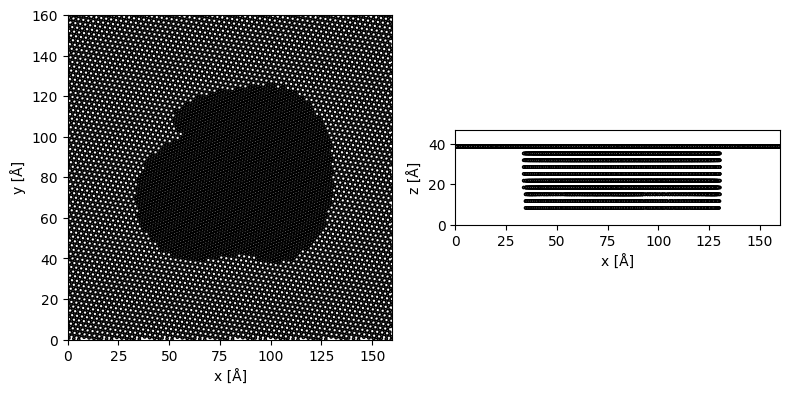

In [3]:
with h5py.File("../data/ducky_coords.mat","r") as f:
    atoms = f['atoms'][:].T
    cell_dim = f['cell_dim'][:].ravel()

ducky_atoms = ase.Atoms(
    numbers=atoms[:,-1],
    positions=atoms[:,:3],
    cell=np.array([160,160,atoms[:,2].max() + atoms[:,2].min()])
)

del ducky_atoms[(ducky_atoms.positions[:,0]<20) | (ducky_atoms.positions[:,0]>180)]
del ducky_atoms[(ducky_atoms.positions[:,1]<20) | (ducky_atoms.positions[:,1]>180)]
ducky_atoms.translate([-20,-20,0])

fig, axs = plt.subplots(1,2,figsize=(8,4))

abtem.show_atoms(ducky_atoms,ax=axs[0],tight_limits=True)
abtem.show_atoms(ducky_atoms,plane='xz',ax=axs[1],tight_limits=True)

fig.tight_layout()

[########################################] | 100% Completed | 838.95 ms
[########################################] | 100% Completed | 207.75 ms


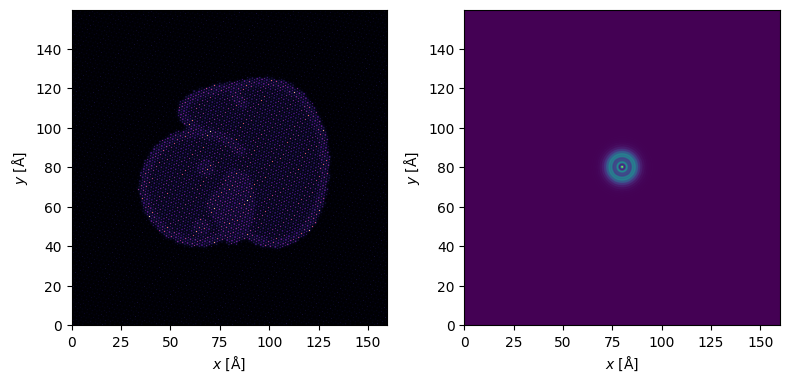

In [9]:
potential = abtem.Potential(
    ducky_atoms,
    gpts=(1600,1600),
    slice_thickness=0.83875,
).build()

probe = abtem.Probe(
    energy=80e3,
    semiangle_cutoff=20,
    defocus=500,
).match_grid(
    potential
)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,4))
    
potential.project().show(
    ax=ax1,
    cmap='magma',
)

probe.show(ax =ax2);

fig.tight_layout()

In [12]:
pixelated_detector = abtem.PixelatedDetector(
    max_angle=None,
)

grid_scan = abtem.GridScan(
    (0, 0), (160,160),
    sampling=4,
    endpoint=True,
)

In [31]:
measurement = probe.scan(
    potential=potential,
    scan=grid_scan,
    detectors=pixelated_detector,
).compute(
)

[########################################] | 100% Completed | 284.64 s


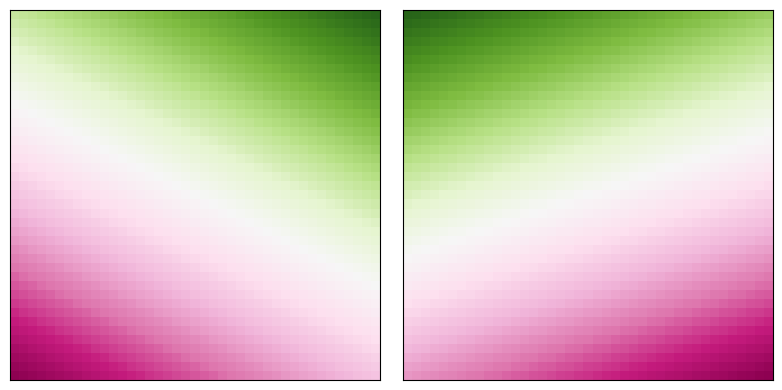

In [13]:
# plane-wave descan
sx, sy = grid_scan.shape
bin_factor = 4

x = np.linspace(-80,80,sx)
y = np.linspace(-80,80,sy)

descan_x = np.round((y[None,:]-2*x[:,None]) / grid_scan.sampling[0])
descan_y = np.round((-y[None,:]-3*x[:,None]) / grid_scan.sampling[1])

fig, axs = plt.subplots(1,2,figsize=(8,4))
axs[0].imshow(descan_x/bin_factor,cmap='PiYG')
axs[1].imshow(descan_y/bin_factor,cmap='PiYG')
for ax in axs:
    ax.set(xticks=[],yticks=[])
fig.tight_layout()

array([400, 400])

In [33]:
crop_x, crop_y = (np.array(potential.gpts) - 200 * bin_factor) // 2
array = np.zeros((sx,sy,200,200),dtype=measurement.array.dtype)
for i in range(sx):
    for j in range(sy):
    
        dp = measurement.array[i,j]
        dp = rotate(dp,15,reshape=False,order=1) # rotate
        dp = np.roll(dp,(int(descan_x[i,j]),int(descan_y[i,j])),axis=(0,1)) # descan
        dp = dp[crop_x:-crop_x,crop_y:-crop_y].reshape((200,bin_factor,200,bin_factor)).sum((1,3)) # bin
        array[i,j] = dp

array_sums = array.sum((-2,-1))
print(f"Smallest array sum (should be close to 1): {array_sums.min()}")

Smallest array sum (should be close to 1): 0.9985268115997314


## Save Multidimensional Dataset
Temporary fix, until abTEM supports zarr>3.

In [35]:
import quantem as em

sampling = [
    grid_scan.sampling[0],
    grid_scan.sampling[1],
    measurement.angular_sampling[0]*bin_factor,
    measurement.angular_sampling[1]*bin_factor,
]

units = ["A","A","mrad","mrad"]

dataset = em.core.datastructures.Dataset4dstem.from_array(
    array,
    sampling=sampling,
    units=units,
)

dataset.save("../data/ducky_20mrad_500A-df_4A-step.zip",mode='o')